# Unsupervised multivariate analyses: PCoA and PERMANOVA 
Authors: M Ernst, F Ottosson, F Russo<br>
Last update: June 28, 2023<br>

In this notebook we will perform a Principal Coordinate Analysis (PCoA), also known as metric or classical Multidimensional Scaling (metric MDS) to explore and visualize patterns in an untargeted mass spectromtery-based metabolomics dataset. We will then assess statistical significance of the patterns and dispersion of different sample types using permutational multivariate analysis of variance (PERMANOVA). <br>

<b>Data</b> <br>

Non-invasive drug monitoring is desirable as it improves patient experience. Instead of relying on invasive blood draws drug pharmacokinetics and metabolism could for example be monitored through the skin. In this tutorial we will be working with a subset of the data published by [Panitchpakdi and collaborators (2022)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0271794). The datasets consists of plasma and skin swabs (forearm, forehead and upper back) collected from healthy volunteers (n=7) over the course of 24 hours, who have been administered the antihistaminic diphenhydramine. 


<b>Questions</b><br>

Using multivariate statistics (PCoA and PERMANOVA) we will explore whether there are significant differences in blood and skin metabolomic profiles over different time points.

# Data clean up

Install and load libraries

In [1]:
# It can take some time in Google Colab
install.packages('vegan')
install.packages('ggplot2')

Warning message in readRDS(dest):
“lzma decoder corrupt data”



The downloaded binary packages are in
	/var/folders/k7/zs6jm5h95875g74l66xfxq6m0000gn/T//RtmpsGODZH/downloaded_packages

The downloaded binary packages are in
	/var/folders/k7/zs6jm5h95875g74l66xfxq6m0000gn/T//RtmpsGODZH/downloaded_packages


In [1]:
library(vegan)
library(ggplot2)

Warning message:
“package ‘vegan’ was built under R version 4.1.2”
Loading required package: permute

Warning message:
“package ‘permute’ was built under R version 4.1.2”
Loading required package: lattice

This is vegan 2.6-4

Warning message:
“package ‘ggplot2’ was built under R version 4.1.2”


In [2]:
# last update
Sys.time()

[1] "2023-07-06 14:33:32 CEST"

Specify where the data can be found by providing urls for the feature table and metadata. Here, we import the files directly from GitHub but you can import them from your local computer or from Google Drive as well of course. 

In [3]:
## feature table
ft_url <- 'https://raw.githubusercontent.com/ssi-dk/CD-MRG-metabolomics_summerschool_2023/main/data/mzmine_output/Example/example_iimn_gnps_quant.csv'
## metadata
md_url <- 'https://raw.githubusercontent.com/ssi-dk/CD-MRG-metabolomics_summerschool_2023/main/data/metadata/metadata.txt'

In [4]:
ft <- read.csv(ft_url, header = T, check.names = F, row.names = 1)
md <- read.csv(md_url, header = T, check.names = F, sep = '\t')

In [5]:
dim(ft)
dim(md)

[1] 6182  101

[1] 172   6

In [6]:
colnames(ft) <- gsub(' Peak area','',colnames(ft))

In [7]:
head(ft, n=2)

,row m/z,row retention time,row ion mobility,row ion mobility unit,row CCS,correlation group ID,annotation network number,best ion,auto MS2 verify,identified by n=,⋯,skin_08_480_UB.mzML,skin_08_0_UB.mzML,skin_08_720_UB.mzML,skin_10_720_UB.mzML,skin_08_120_UB.mzML,skin_03_120_UB.mzML,skin_03_240_UB.mzML,skin_03_0_UB.mzML,skin_08_600_UB.mzML,
,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<chr>,<lgl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
9002,150.0629,4.962805,NA,NA,NA,20,144,[M+H]+,NA,2,⋯,900854.3,1083294,1015355,1320949.000,1210521,2636820,2352654,2145513,866366.8,NA
8808,150.5959,4.821733,NA,NA,NA,NA,NA,,NA,NA,⋯,0.0,0,0,3297.581,0,0,0,0,0.0,NA


In [8]:
head(md, n=2)

,filename,ATTRIBUTE_Sample_Type,ATTRIBUTE_Subject,ATTRIBUTE_Timepoint_min,ATTRIBUTE_Sampling_Location,ATTRIBUTE_Analysis_order
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,bld_plt1_01_0_1.mzML,plasma,Subject_1,0,not applicable,19
2,bld_plt1_01_120_1.mzML,plasma,Subject_1,120,not applicable,32


<b>Bring featuretable and metadata in the correct format:</b><br>

In [9]:
# name rows in metadata after filenames
rownames(md) <- md$filename

In [10]:
# how many files in the metadata are also present in the feature table
table(rownames(md) %in% colnames(ft))


FALSE  TRUE 
   84    88 

In [11]:
head(md)

,filename,ATTRIBUTE_Sample_Type,ATTRIBUTE_Subject,ATTRIBUTE_Timepoint_min,ATTRIBUTE_Sampling_Location,ATTRIBUTE_Analysis_order
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
bld_plt1_01_0_1.mzML,bld_plt1_01_0_1.mzML,plasma,Subject_1,0,not applicable,19
bld_plt1_01_120_1.mzML,bld_plt1_01_120_1.mzML,plasma,Subject_1,120,not applicable,32
bld_plt1_01_600_1.mzML,bld_plt1_01_600_1.mzML,plasma,Subject_1,600,not applicable,51
bld_plt1_01_720_1.mzML,bld_plt1_01_720_1.mzML,plasma,Subject_1,720,not applicable,50
bld_plt1_03_0_1.mzML,bld_plt1_03_0_1.mzML,plasma,Subject_3,0,not applicable,20
bld_plt1_03_480_1.mzML,bld_plt1_03_480_1.mzML,plasma,Subject_3,480,not applicable,52


In [12]:
# which column names in the the feature table are not in the metadata?
colnames(ft)[-which(colnames(ft) %in% rownames(md))]

[1] "row m/z"                   "row retention time"       
 [3] "row ion mobility"          "row ion mobility unit"    
 [5] "row CCS"                   "correlation group ID"     
 [7] "annotation network number" "best ion"                 
 [9] "auto MS2 verify"           "identified by n="         
[11] "partners"                  "neutral M mass"           
[13] ""

Next we remove all samples in the metadata, which are not in the feature table and all columns in the feature table which are not in the metadata

In [13]:
ft <- ft[,which(colnames(ft) %in% rownames(md))]

In [14]:
md <- md[rownames(md) %in% colnames(ft),]

In [15]:
dim(md)
dim(ft)

[1] 88  6

[1] 6182   88

In [16]:
# transpose ft
ft <- t(ft)

In [17]:
dim(ft)

[1]   88 6182

In [18]:
head(ft, n=2)

,9002,8808,4094,2584,5788,5122,598,1334,649,2884,⋯,7209,7274,14656,7238,14458,14686,14690,14715,14730,7267
bld_plt2_blk_04.mzML,260.5778,0,0.000,0.00,14.45017,0.00,0.00,0.00,0.000,10.07951,⋯,37.94781,20.07441,0,24.93487,0,0.0000,0.0000,0.0000,0.0000,24.29009
skin_07_0_UB.mzML,1059784.4000,0,8228.722,12411.19,15416.69000,15043.91,7093.19,46066.15,4023.823,48443.41400,⋯,0.00000,0.00000,0,0.00000,0,677.4758,250.9794,116.5564,95.1639,0.00000


# Principal Coordinates Analysis (PCoA) and Permutational Multivariate Analysis of Variance (PERMANOVA)

## Principal coordinates analysis (PCoA)

Principal coordinates analysis (PCoA) is a metric multidimensional scaling (MDS) method that attempts to represent sample dissimilarities in a low-dimensional space. It converts a distance matrix consisting of pair-wise distances (dissimilarities) across samples into a 2- or 3-D graph ([Gower, 2005](https://onlinelibrary.wiley.com/doi/10.1002/0470011815.b2a13070)). Different distance metrics can be used to calculate dissimilarities among samples (e.g. Euclidean, Canberra, Minkowski). Performing a principal coordinates analysis using the Euclidean distance metric is the same as performing a principal components analysis (PCA). The selection of the most appropriate metric depends on the nature of your data and assumptions made by the metric.<br>

Within the metabolomics field the Euclidean, Bray-Curtis, Jaccard or Canberra distances are most commonly used. The Jaccard distance is an unweighted metric (presence/absence) whereas Euclidean, Bray-Curtis and Canberra distances take into account relative abundances (weighted). Some metrics may be better suited for very sparse data (with many zeroes) than others. For example, the Euclidean distance metric is not recommended to be used for highly sparse data. <br>

This video tutorial by StatQuest summarizes nicely the basic principles of PCoA: https://www.youtube.com/watch?v=GEn-_dAyYME<br>

In order to perform a PCoA as described below, it is important that the filenames in our metadata are identical as well as in the same order as the filenames in our feature table. Let's make sure this is true, using the below code (this should return TRUE).

In [19]:
identical(rownames(ft),rownames(md))
# put the rows in the feature table and metadata in the same order
ft <- ft[match(rownames(md),rownames(ft)),]
identical(rownames(ft),rownames(md))

[1] FALSE

[1] TRUE

Now, let's scale and center the data.

In [20]:
fts <- scale(ft, scale = TRUE, center = TRUE)

Next, we will calculate pairwise distances across all samples using the Euclidean distance metric.

In [21]:
distm <- dist(fts, method = 'euclidean')

All pairwise Euclidean distances are now stored within our distance (dissimilarity) matrix (distm). The distance matrix is then used as input for the PCoA. At first, we here color samples according to the sample types (ATTRIBUTE_Sample within our metadata)

In [22]:
colnames(md)

[1] "filename"                    "ATTRIBUTE_Sample_Type"      
[3] "ATTRIBUTE_Subject"           "ATTRIBUTE_Timepoint_min"    
[5] "ATTRIBUTE_Sampling_Location" "ATTRIBUTE_Analysis_order"

In [23]:
table(md$ATTRIBUTE_Sample_Type)
table(md$ATTRIBUTE_Subject)
table(md$ATTRIBUTE_Timepoint_min)
table(md$ATTRIBUTE_Sampling_Location)


      plasma plasma_blank         skin   skin_blank 
          42            2           42            2 


not applicable      Subject_1     Subject_10      Subject_3      Subject_4 
             4             12             12             12             12 
     Subject_5      Subject_7      Subject_8 
            12             12             12 


             0            120            240            480            600 
            14             14             14             14             14 
           720 not applicable 
            14              4 


not applicable     upper back 
            46             42 

In [24]:
PcoA <- cmdscale(distm, k = 2, eig = T, add = T)
PcoA_points <- as.data.frame(PcoA$points)
variance <- round(PcoA$eig*100/sum(PcoA$eig),1)
names(PcoA_points)[1:2] <- c('PCoA1', 'PCoA2')

In [25]:
head(PcoA_points)

,PCoA1,PCoA2
,<dbl>,<dbl>
bld_plt1_01_0_1.mzML,-48.82978,-1.68282255
bld_plt1_01_120_1.mzML,-49.64844,-3.90187090
bld_plt1_01_600_1.mzML,-48.87658,-2.34792649
bld_plt1_01_720_1.mzML,-48.16725,1.02907212
bld_plt1_03_0_1.mzML,-46.94004,0.08771298
bld_plt1_03_480_1.mzML,-46.33082,0.76577957


In [26]:
identical(rownames(PcoA_points), rownames(md))

[1] TRUE

Using the [ggplot2](https://cran.r-project.org/web/packages/ggplot2/index.html) library, we can plot our PCoA using the Euclidean distance (=PCA).

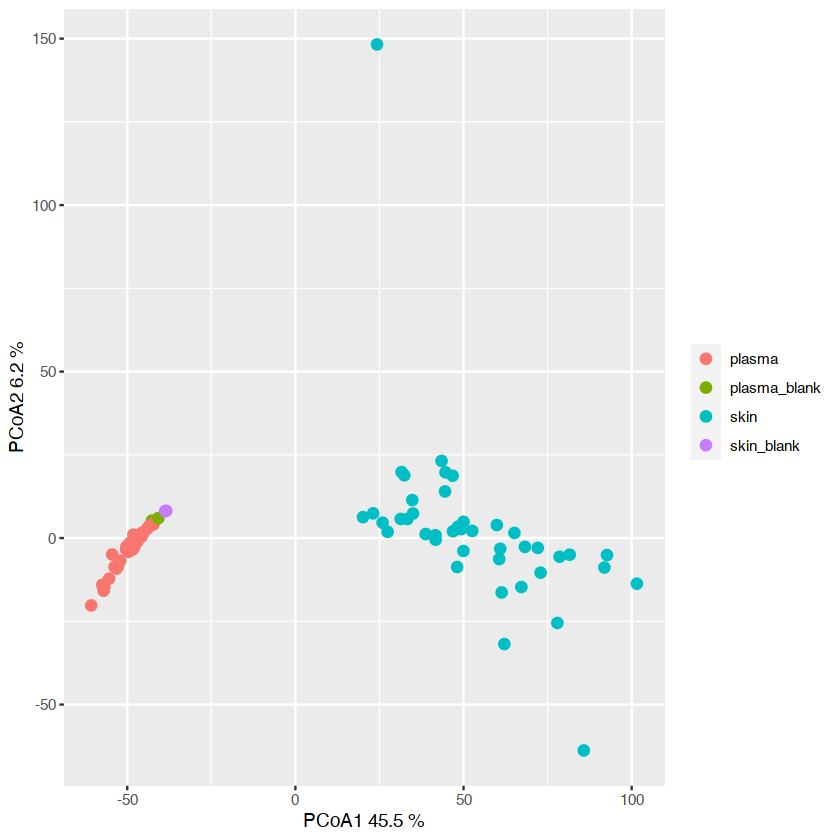

In [27]:
ggplot(PcoA_points, aes(x = PCoA1, y = PCoA2, colour = md$ATTRIBUTE_Sample_Type, label = row.names(PcoA))) + geom_point(size=2.5) +
            #scale_colour_manual(values = c('orange','darkgreen','red','blue','black')) +
            xlab(paste('PCoA1',variance[1],'%', sep = ' ')) +
            ylab(paste('PCoA2',variance[2],'%', sep = ' ')) +
            theme(legend.title=element_blank())

As expected, it looks like skin and plasma samples from the same individuals exhibit very different metabolomic profiles. But is this difference significant? Let's perform a permutational multivariate analysis of variance (PERMANOVA) to find out!

## Permutational multivariate analysis of variance (PERMANOVA)

Permutational multivariate analysis of variance (PERMANOVA) is a non-parametric method for multivariate analysis of variance, where P-values are obtained using permutations. The metric was originally developed within the field of ecology ([Anderson, 2008](https://onlinelibrary.wiley.com/doi/full/10.1002/9781118445112.stat07841)) but is today widely used in other fields, including the microbiome and metabolomics field. PERMANOVA is used to compare groups of samples and tests whether the centroid and/or the spread of the samples is different between the groups.<br>

The adonis2() function in the [vegan package](https://cran.r-project.org/web/packages/vegan/index.html) can be used to perform a PERMANOVA. The input is any dissimilarity matrix and the test-statistic retrieved is a multivariate analogue to Fisher's F-ratio as well as an R2 value (Adonis R2).

In [28]:
adonres <- adonis2(distm ~ md[,colnames(md) == 'ATTRIBUTE_Sample_Type'])

In [29]:
adonres

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"md[, colnames(md) == ""ATTRIBUTE_Sample_Type""]",3,233688.6,0.4344995,21.51366,0.001
Residual,84,304145.4,0.5655005,NA,NA
Total,87,537834.0,1.0000000,NA,NA


The PERMANOVA test result tells us that there is a significant difference in the metabolomic profiles of different sample types (PERMANOVA, P < 0.05, Adonis R2 = 0.43) and that app. 43% of the variation in our data can be explained by sample type. 

## Perform PCoA and assess separation using PERMANOVA

To speed up the analysis and so we don't have to rewrite the entire code when testing different parameters, we can define a function, which will perform a principal coordinates analysis (PCoA) using a distance metric of choice, calculate a PERMANOVA and plot results in a 2-D graph:

In [30]:
plotPCoA <- function(ft, md, distmetric = c("euclidean", "maximum", "manhattan", "canberra", "binary", 
                                                  "minkowski"), collow = "#810f7c", colhigh ="#f7fcb9", 
                      catper = "plate", catcols = "plate", mdtype = 'categorical', 
                      cols = c('grey','black','orange','pink','darkgreen','darkred','brown','blue','skyblue3','green'),
                      title = 'Principal coordinates plot'){
    
    catper <<- catper
    distm <- dist(ft, method = distmetric)
    d <- as.matrix(distm)

    if (length(which(is.na(md[,colnames(md) == catper]))) !=0){
          red <- as.dist(as.matrix(distm)[-which(is.na(md[,colnames(md) == catper])),-which(is.na(md[,colnames(md) == catper]))])
          adonres <- adonis2(red ~ na.omit(md[,colnames(md) == catper]))
          Rsq <- adonres$R2[1]
          pval <- adonres$'Pr(>F)'[1]
        } else {
          adonres <- adonis2(distm ~ md[,colnames(md) == catper])
          Rsq <- adonres$R2[1]
          pval <- adonres$'Pr(>F)'[1]
        }

    PcoA <- cmdscale(distm, k =2, eig = T, add = T)
    PcoA_points <- as.data.frame(PcoA$points)
    variance <- round(PcoA$eig*100/sum(PcoA$eig),1)
    names(PcoA_points)[1:2] <- c('PCoA1', 'PCoA2')
    PcoA_points <- as.data.frame(PcoA_points)
    PcoA_points$Group <- md[,colnames(md) == catcols][match(rownames(PcoA_points),rownames(md))]
    names(PcoA_points)[1:2] <- c('PCoA1', 'PCoA2')
    
    # plot
    cbPalette <- cols

    if (mdtype == 'continuous'){
          Tr_PcoA <- ggplot(PcoA_points, aes(x = PCoA1, y = PCoA2, colour = Group, label = row.names(PcoA))) + geom_point(size=2.5) +
            scale_colour_gradient(low = collow, high = colhigh,space = "Lab", na.value = "grey50", guide = "colourbar",aesthetics = "colour")+
            theme(legend.title=element_blank()) +
            xlab(paste('PCoA1',variance[1],'%', sep = ' ')) +
            ylab(paste('PCoA2',variance[2],'%', sep = ' ')) +
            ggtitle(paste(title,paste0("(p=",round(pval,4),","),paste0("adonis-R2=",round(Rsq,4),")"),sep=" "))

        } else {

          Tr_PcoA <- ggplot(PcoA_points, aes(x = PCoA1, y = PCoA2, colour = Group, label = row.names(PcoA))) + geom_point(size=2.5) +
            scale_colour_manual(values = cbPalette) +
            theme(legend.title=element_blank()) +
            xlab(paste('PCoA1',variance[1],'%', sep = ' ')) +
            ylab(paste('PCoA2',variance[2],'%', sep = ' ')) +
            ggtitle(paste(title,paste0("(p=",round(pval,4),","),paste0("adonis-R2=",round(Rsq,4),")"),sep=" "))
        }
    
    print(Tr_PcoA)
}

By defining different parameters within the plotPCoA function:<br>

- <b>distmetric</b>: A distance metric of your choice, including "euclidean", "maximum", "manhattan", "canberra", "binary" or "minkowski".<br>
- <b>catper</b>: How should the samples be grouped for PERMANOVA, this can be any column name of your metadata.<br>
- <b>catcols</b>: According to what groups should the samples be colored on the PCoA, this can be any column name of your metadata.<br>
- <b>mdtype</b>: Either 'categorical' or 'continuous', this value defines whether a continuous or categorical color scale should be used for the PCoA. <br>
- <b>cols</b>: Colors used for plotting the groups in the PCoA. The length of this object should be equal to the number of groups plotted.<br>
- <b>title</b>: Any title of your choice you want to give the plot.<br>

we can quickly draw the same PCoA plot as above and retrieve PERMANOVA test results at the same time.

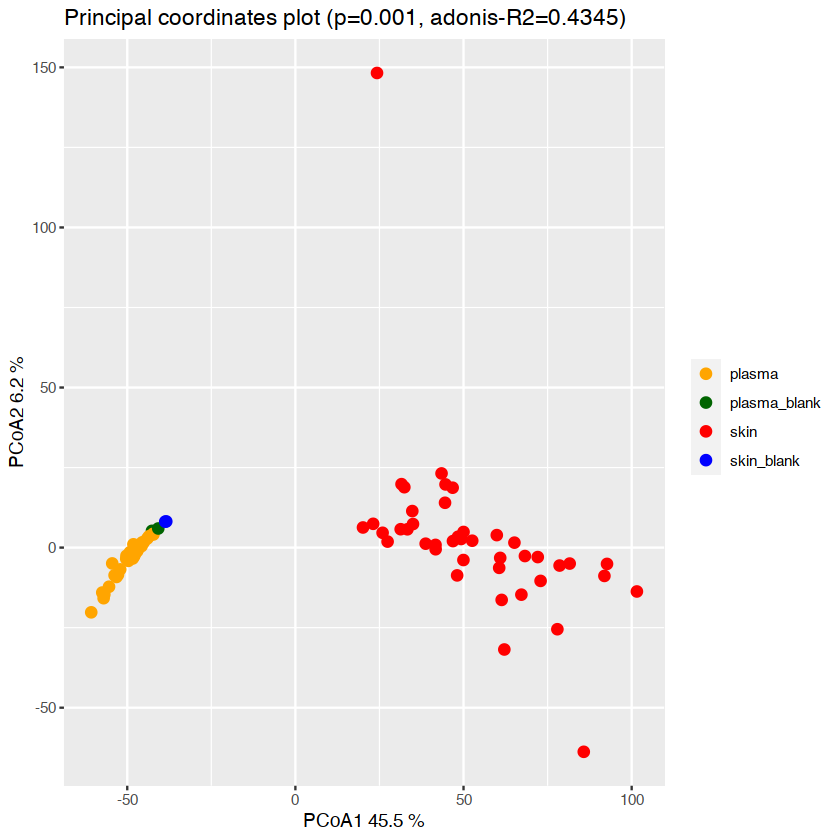

In [31]:
plotPCoA(fts, md, distmetric = "euclidean", catper = "ATTRIBUTE_Sample_Type", catcols = "ATTRIBUTE_Sample_Type", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','blue','black'),
                      title = 'Principal coordinates plot')

### Investigate sample groups separately

To investigate whether metabolomic profiles differ across different time points, investigate skin and plasma samples separately.


<b>Skin samples</b><br>

In [32]:
md_skin <- md[which(md$ATTRIBUTE_Sample_Type == 'skin'),]

In [33]:
md_skin$ATTRIBUTE_Timepoint_min <- as.numeric(md_skin$ATTRIBUTE_Timepoint_min)

In [34]:
length(which(rownames(ft) %in% md_skin$filename))

[1] 42

In [35]:
fts_skin <- fts[which(rownames(fts) %in% md_skin$filename),]

In [36]:
identical(rownames(fts_skin), md_skin$filename)

[1] TRUE

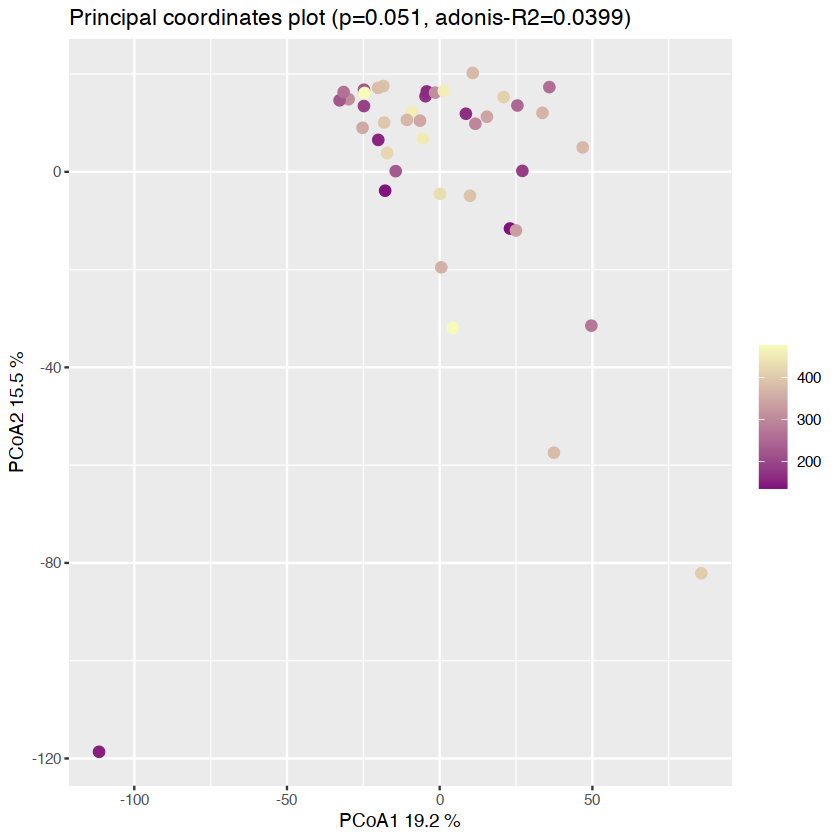

In [37]:
plotPCoA(fts_skin, md_skin, distmetric = "euclidean", catper = "ATTRIBUTE_Analysis_order", catcols = "ATTRIBUTE_Analysis_order", mdtype = 'continuous', 
                      title = 'Principal coordinates plot')

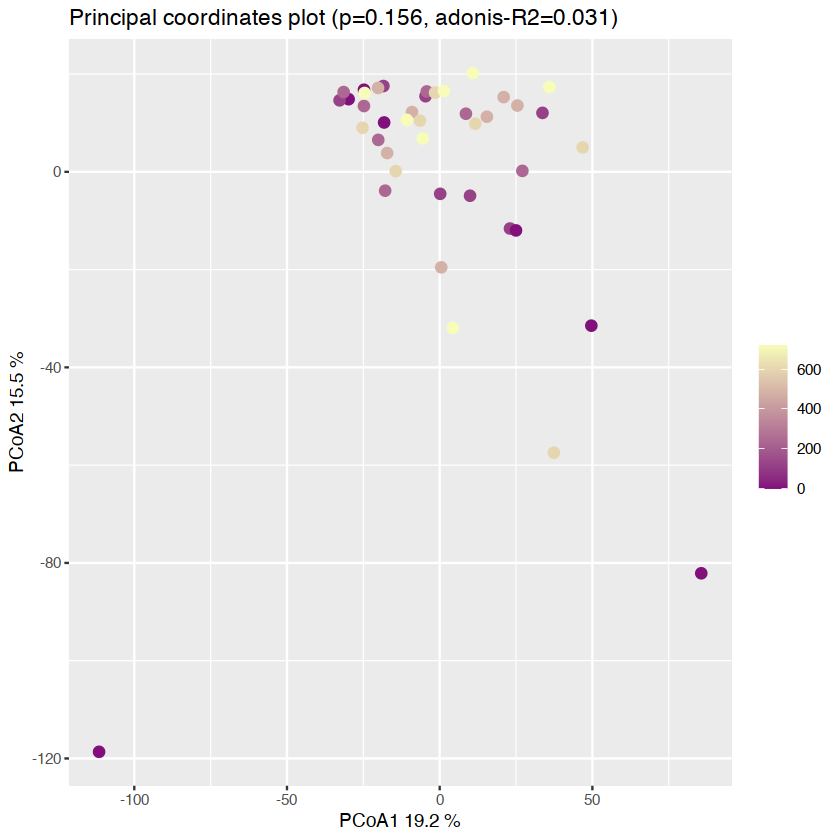

In [38]:
plotPCoA(fts_skin, md_skin, distmetric = "euclidean", catper = "ATTRIBUTE_Timepoint_min", catcols = "ATTRIBUTE_Timepoint_min", mdtype = 'continuous', 
                      title = 'Principal coordinates plot')

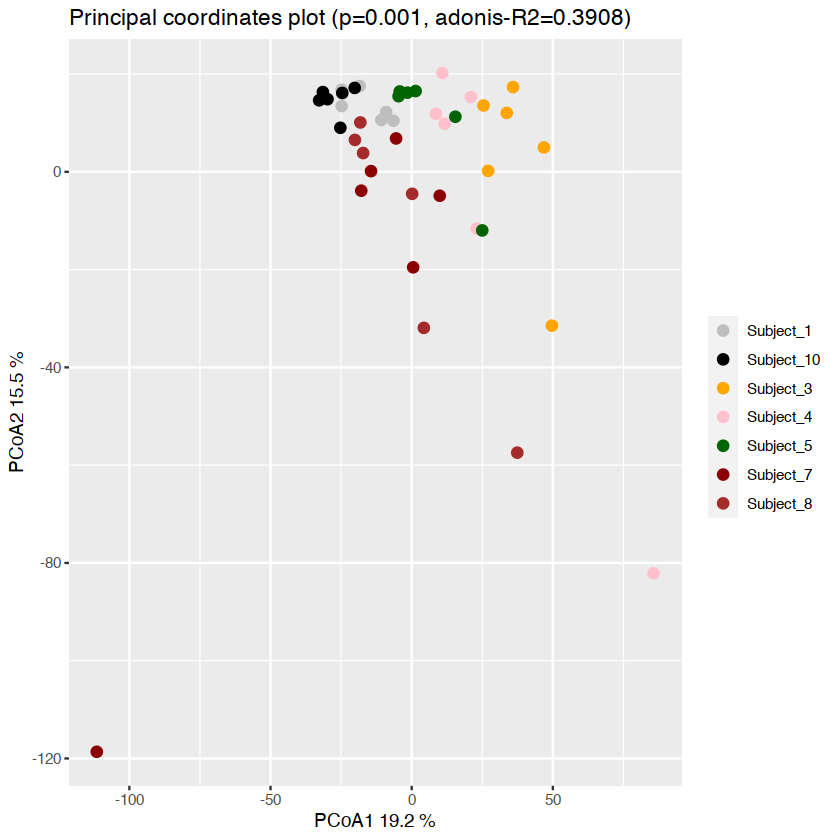

In [39]:
plotPCoA(fts_skin, md_skin, distmetric = "euclidean", catper = "ATTRIBUTE_Subject", catcols = "ATTRIBUTE_Subject", mdtype = 'categorical', 
                      title = 'Principal coordinates plot')

We can see that skin metabolomic profiles do not differ significantly across time points (PERMANOVA, P > 0.05) but do differ significantly across individuals (PERMANOVA, P < 0.05). Approximately 39% of the variation in the skin metabolome can be explained by subject ID (Adonis R2 = 0.39). We also observe a marginally significant effect of analysis run order (PERMANOVA, P = 0.51).

<b>Plasma samples</b><br>

In [40]:
md_plasma <- md[which(md$ATTRIBUTE_Sample_Type == 'plasma'),]

In [41]:
md_plasma$ATTRIBUTE_Timepoint_min <- as.numeric(md_plasma$ATTRIBUTE_Timepoint_min)

In [42]:
length(which(rownames(ft) %in% md_plasma$filename))

[1] 42

In [43]:
fts_plasma <- fts[which(rownames(fts) %in% md_plasma$filename),]

In [44]:
identical(rownames(fts_plasma), md_plasma$filename)

[1] TRUE

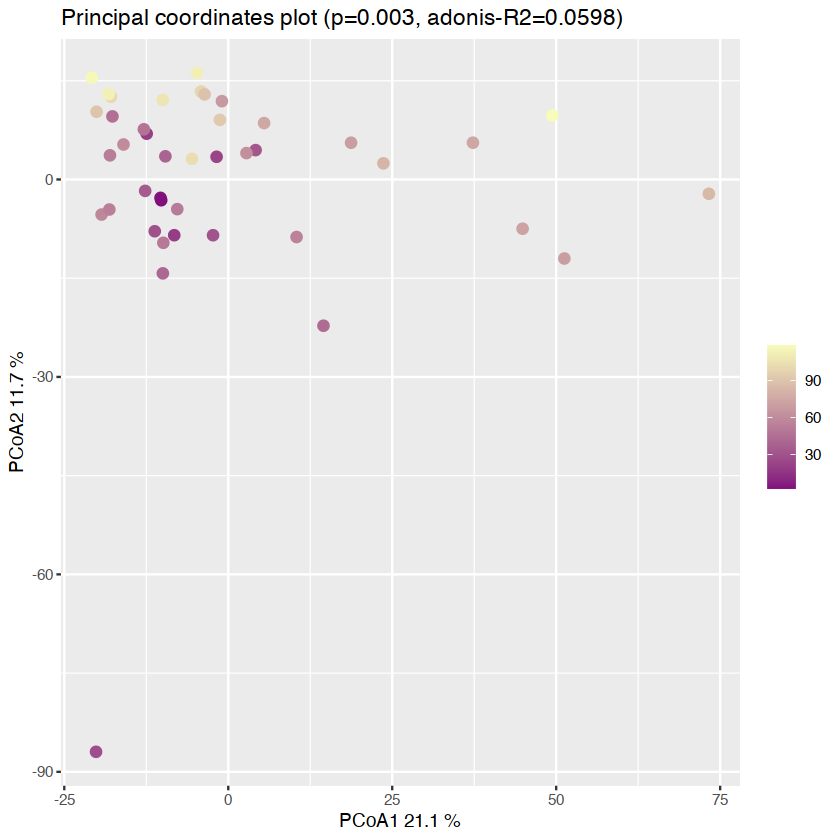

In [45]:
plotPCoA(fts_plasma, md_plasma, distmetric = "euclidean", catper = "ATTRIBUTE_Analysis_order", catcols = "ATTRIBUTE_Analysis_order", mdtype = 'continuous', 
                      title = 'Principal coordinates plot')

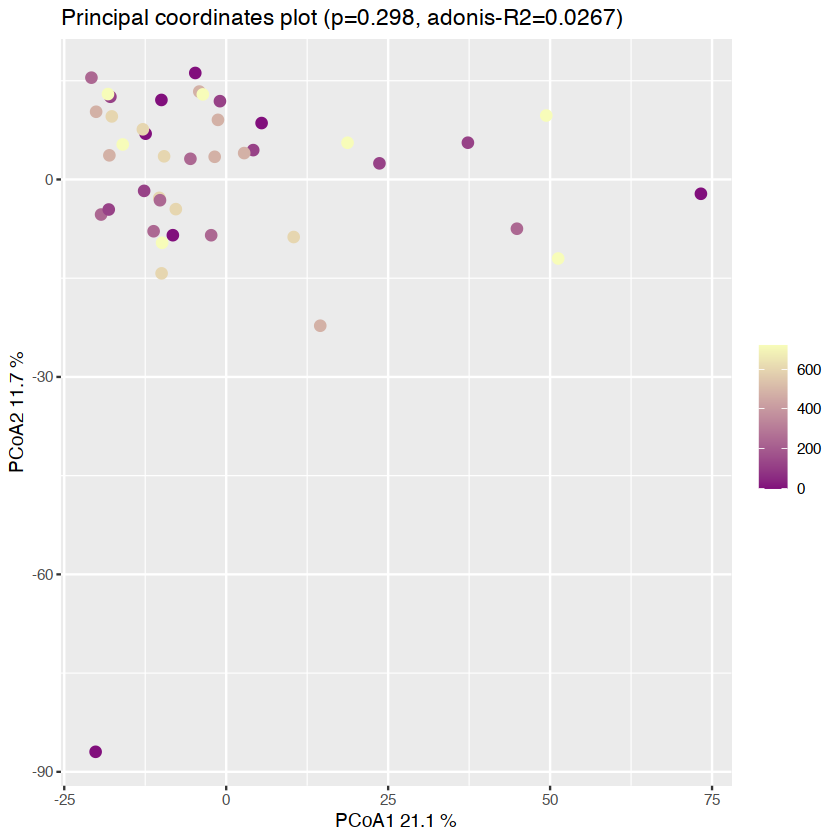

In [46]:
plotPCoA(fts_plasma, md_plasma, distmetric = "euclidean", catper = "ATTRIBUTE_Timepoint_min", catcols = "ATTRIBUTE_Timepoint_min", mdtype = 'continuous', 
                      title = 'Principal coordinates plot')

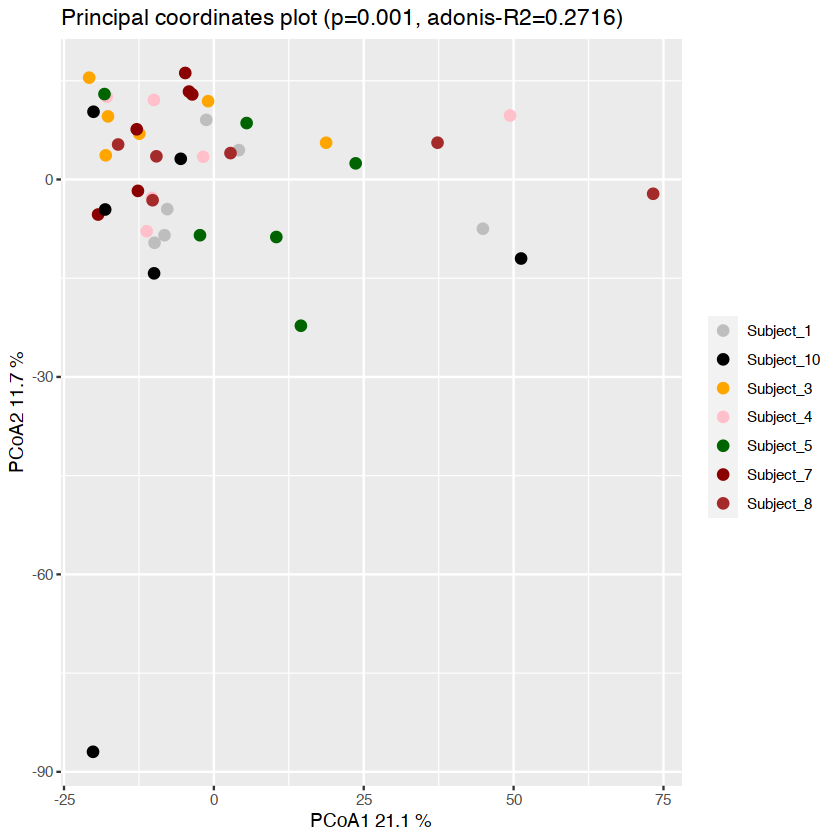

In [47]:
plotPCoA(fts_plasma, md_plasma, distmetric = "euclidean", catper = "ATTRIBUTE_Subject", catcols = "ATTRIBUTE_Subject", mdtype = 'categorical', 
                      title = 'Principal coordinates plot')

Interestingly, there are also no significant differences in metabolomic plasma profiles across different sampling timepoints (PERMANOVA, P > 0.05). Around 27% of the variation in plasma metabolomic profiles can be explained by subject ID (PERMANOVA, P < 0.05, Adonis R2 = 0.24), and around 6% can be explained by the analysis run order (PERMANOVA, P < 0.05, Adonis R2 = 0.06).

- We can also test a different distance metric and look at the separation of samples (e.g. Canberra).

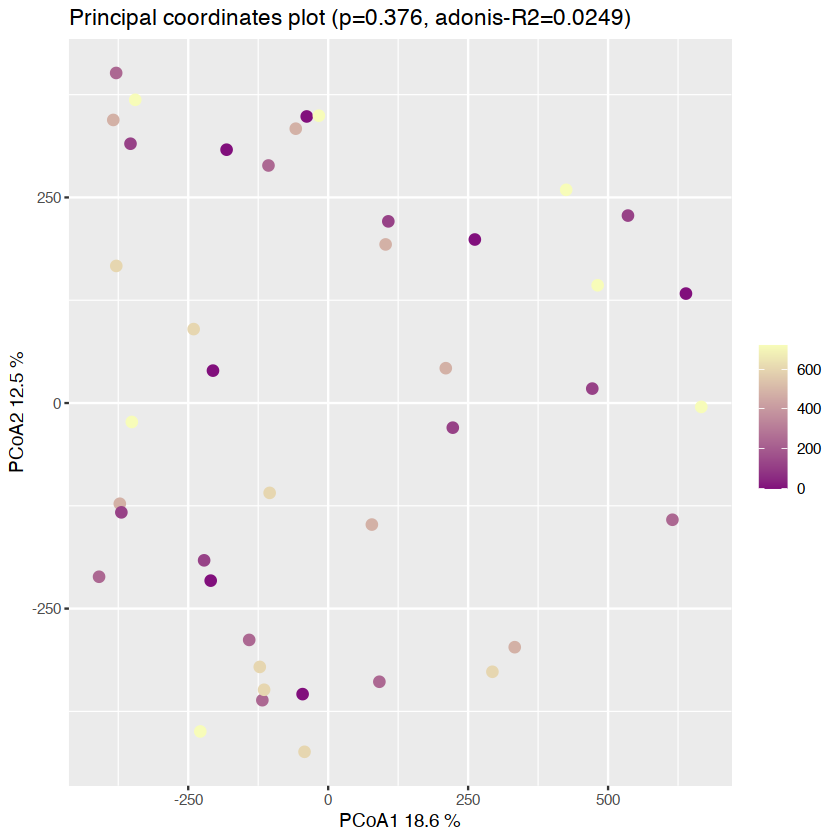

In [48]:
plotPCoA(fts_plasma, md_plasma, distmetric = "canberra", catper = "ATTRIBUTE_Timepoint_min", catcols = "ATTRIBUTE_Timepoint_min", mdtype = 'continuous', 
                      title = 'Principal coordinates plot')

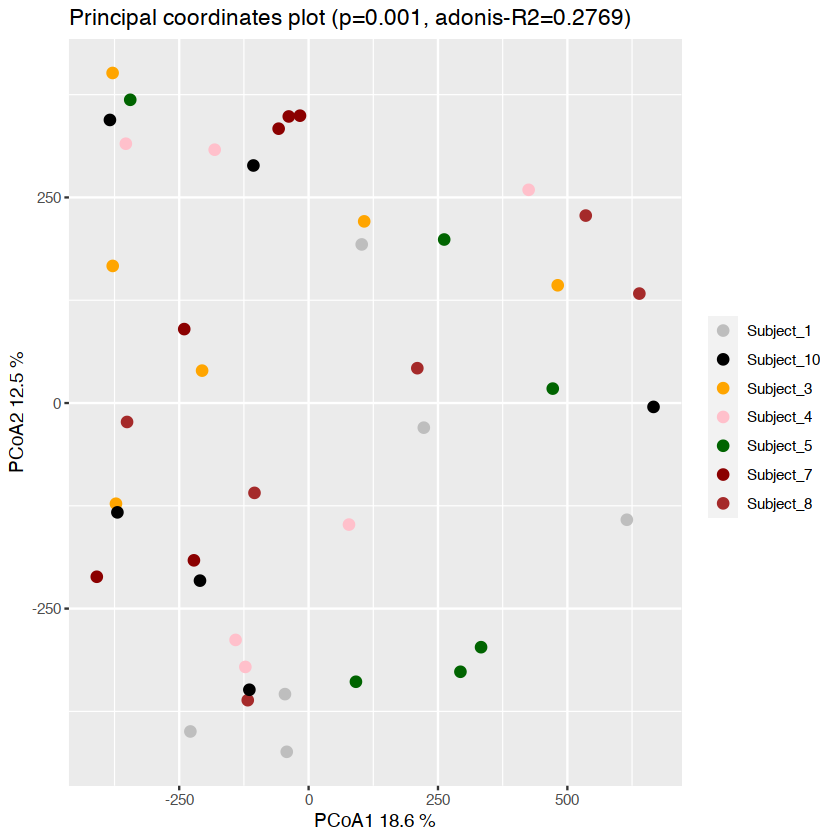

In [49]:
plotPCoA(fts_plasma, md_plasma, distmetric = "canberra", catper = "ATTRIBUTE_Subject", catcols = "ATTRIBUTE_Subject", mdtype = 'categorical', 
                      title = 'Principal coordinates plot')

Using the Canberra distance metric, we can observe the same trends.

Now let's export the figure we want to use for our manuscript in .pdf 

In [50]:
pdf("PCoA_plasma.pdf")
plotPCoA(fts_plasma, md_plasma, distmetric = "canberra", catper = "ATTRIBUTE_Timepoint_min", catcols = "ATTRIBUTE_Timepoint_min", mdtype = 'continuous', 
                      title = 'Principal coordinates plot')
dev.off()

pdf 
  2

In [51]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.4.2   vegan_2.6-4     lattice_0.20-44 permute_0.9-7  

loaded via a namespace (and not attached):
 [1] pillar_1.8.1     compiler_4.1.1   base64enc_0.1-3  tools_4.1.1     
 [5] digest_0.6.31    uuid_1.1-0       tibble_3.1.8     jsonlite_1.8.4  
 [9] evaluate_0.20    lifecycle_1.0.3  nlme_3.1-152     gtable_0.3.1    
[13] mgcv_1.8-36      pkgconfig_2.0.3  rlang_1.1.1      Matrix_1.3-4    
[17] IRdisplay_1.1    cli_3.6.0        IRkernel_1.2     parallel_4.1.1  
[21] fastmap_1.1.0    